In [1]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras import utils as np_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import load_model


Using TensorFlow backend.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle

In [3]:
def read_file():
    path = './Five_category_data.csv'
    df = pd.read_csv(path, encoding = 'unicode_escape').astype("str")
#     print(df)
#     print(df[['content','category']].head(5))
    return df
    
# read_file()

In [4]:
num = 0
data_list = []
contents = []
categories = []
drop_out_categories = []
df = read_file()
df = df[['content','category']]
change_to_number = df.replace({'Video_Game_Category':0, 
                                'Community':1, 
                                'Food':2, 
                                'International':3, 
                                'Entertainment':4})
# print(change_to_number)
final_df = change_to_number[change_to_number['category'].isin([0, 1, 2, 3, 4])]
# print(final_df)

data_list = final_df.values.tolist()
random.shuffle(data_list)
for data in data_list:
    data[0], data[1]
    contents.append(data[0])
#categories.append(data[1])

token = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', lower=None, split=" ", char_level=False)
token.fit_on_texts(contents)
# print(token.document_count)
# print(token.word_index)

with open('./Models/nlp_model_E01_token.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [5]:
loadtrainlst, temp = train_test_split(data_list, test_size=0.5, random_state=42)
loadvaildlst, loadtestlst = train_test_split(temp, test_size=0.5, random_state=42)
# for data in data_list:
#     print(data[1])
x_loadtrain = []
y_loadtrain = []
for train_data in loadtrainlst:
    train_data[0], train_data[1]
    x_loadtrain.append(train_data[0])
    y_loadtrain.append(train_data[1])

x_loadvalid = []
y_loadvalid = []
for valid_data in loadvaildlst:
    valid_data[0], valid_data[1]
    x_loadvalid.append(valid_data[0])
    y_loadvalid.append(valid_data[1])
    
x_loadtest = []
y_loadtest = []
for test_data in loadtestlst:
    test_data[0], test_data[1]
    x_loadtest.append(test_data[0])
    y_loadtest.append(test_data[1])

x_train_seq = token.texts_to_sequences(x_loadtrain)
x_valid_seq = token.texts_to_sequences(x_loadvalid)
x_test_seq = token.texts_to_sequences(x_loadtest)

x_train = sequence.pad_sequences(x_train_seq, maxlen = 500)
x_valid = sequence.pad_sequences(x_valid_seq, maxlen = 500)
x_test = sequence.pad_sequences(x_test_seq, maxlen = 500)

y_loadtrain = np.array(y_loadtrain)
y_loadvalid = np.array(y_loadvalid)
y_loadtest = np.array(y_loadtest)


In [6]:
y_tr_OneHot = np_utils.to_categorical(y_loadtrain, 5)
y_va_OneHot = np_utils.to_categorical(y_loadvalid, 5)
y_te_OneHot = np_utils.to_categorical(y_loadtest, 5)

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

In [16]:
model_name = 'nlp_model_E01'
model = Sequential()
model.add(Embedding(output_dim=32,
                    input_dim=5000,
                    input_length=500))
# model.add(Dropout(0.35))
model.add(GRU(32))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(units=5,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 175,973
Trainable params: 175,973
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [18]:
model_train_loss_fullmode = ModelCheckpoint('./Models/%s_train_loss_weight.h5' % model_name,
                                                            monitor='loss',
                                                            save_best_only=True,
                                                            mode='min')

In [19]:
model_train_val_loss_fullmode = ModelCheckpoint('./Models/%s_train_val_loss_weight.h5' % model_name,
                                                            monitor='val_loss',
                                                            save_best_only=True,
                                                            mode='min')

In [20]:
yaml_string = model.to_yaml()
yamlfilepath = './Models/' + model_name + '_' + '.yaml'
with open(yamlfilepath, 'w') as outfile:
    outfile.write(yaml_string)

In [21]:
train_history=model.fit(x_train, 
                        y_tr_OneHot, 
                        validation_data = [x_valid, y_va_OneHot],
                        batch_size=100,
                        epochs=10, 
                        verbose=2,
                        callbacks=[model_train_loss_fullmode, model_train_val_loss_fullmode])

Train on 10874 samples, validate on 5437 samples
Epoch 1/10
 - 165s - loss: 0.6649 - accuracy: 0.8392 - val_loss: 0.0492 - val_accuracy: 0.9860
Epoch 2/10
 - 157s - loss: 0.0182 - accuracy: 0.9953 - val_loss: 0.0193 - val_accuracy: 0.9939
Epoch 3/10
 - 169s - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.0107 - val_accuracy: 0.9974
Epoch 4/10
 - 163s - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0110 - val_accuracy: 0.9974
Epoch 5/10
 - 148s - loss: 7.4424e-04 - accuracy: 0.9997 - val_loss: 0.0118 - val_accuracy: 0.9972
Epoch 6/10
 - 142s - loss: 2.1464e-04 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9980
Epoch 7/10
 - 149s - loss: 1.1844e-04 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9980
Epoch 8/10
 - 146s - loss: 8.1514e-05 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9980
Epoch 9/10
 - 172s - loss: 6.3659e-05 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9980
Epoch 10/10
 - 162s - loss: 5.3861e-05 - accuracy: 1.0000 - val_loss: 0.0119

In [22]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

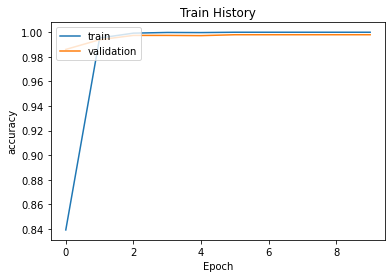

In [23]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

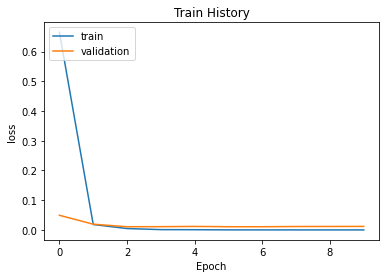

In [24]:
show_train_history(train_history, 'loss', 'val_loss')

In [25]:
scores = model.evaluate(x_test, y_te_OneHot, verbose=1)
scores[1]

5438/5438 [==============================] - 33s 6ms/step


0.9961382746696472

In [27]:
predict = model.predict_classes(x_test)
# predict = (model.predict(x_test) > 0.5).astype("int32")
# predict[:10]
predict.shape
predict_classes=predict.reshape(5438)
predict_classes

array([1, 2, 4, ..., 1, 0, 2])

In [28]:
SentimentDict={0:'Video_Game_Category',1:'Community',2:'Food',3:'International',4:'Entertainment'}
def display_test_Sentiment(i):
    print(x_test[i])
    print('label：',SentimentDict[y_loadtest[i]],
         'prediction：',SentimentDict[predict_classes[i]])
    
# display_test_Sentiment(6)



In [29]:
def predict_article(input_text):
    input_seq = token.texts_to_sequences([input_text])
    pad_input_seq = sequence.pad_sequences(input_seq, maxlen = 500)
    predict_result = model.predict_classes(pad_input_seq)
    print(SentimentDict[predict_result[0]])

predict_article('''
The PlayStation 5 and Xbox Series X / S have been out for a few weeks now. And while we’ve been loving next-gen titles like Astro’s Playroom and Spider-Man: Miles Morales, many Verge staffers have been marveling at something unexpected: older games on newer consoles.

Thanks to more powerful hardware, many games now have more stable resolutions, better frame rates, and faster load times, which makes playing them even better than before. And the PlayStation Plus Collection and Xbox Game Pass offer a plethora of older titles at a monthly price that’s far cheaper than a brand-new next-gen game.

We’ve all spent time with different games, so our newsroom wanted to share some of our experiences in case you’ve been wondering just how well older games might fare on the PS5 and Xbox Series consoles.
''')

Video_Game_Category


In [30]:
pd.crosstab(y_loadtest, predict,
           rownames=['label'],colnames=['predict'],
           margins=True)

predict,0,1,2,3,4,All
label,,,,,,
0,970,0,0,0,10,980
1,0,1297,0,0,0,1297
2,4,1,1004,0,2,1011
3,0,0,0,1019,0,1019
4,3,0,1,0,1127,1131
All,977,1298,1005,1019,1139,5438
